In [7]:
import math

In [8]:
class Value:

    def __init__(self, data, _children = (), _op = ()):
        self.data = data
        self._op = _op
        self._prev = set(_children)
        self.grad = 0.0
        self._backward = lambda : None

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __pow__(self, other):
        assert isinstance(other, (int,float))
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
           self.grad += 1.0 * out.grad
           other.grad += 1.0 * out.grad

        
        out._backward = _backward
        return out 
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, (self,other), '*')
        
        def _backward():
           self.grad += other.data * out.grad
           other.grad += self.data * out.grad
        
        out._backward = _backward
        return out 
    
    def __rmul__(self, other):
        return self*other
    
    def __radd__(self, other):
        return self+other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def tanh(self):
         x = self.data
         t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
         out = Value(t, (self,), 'tanh')

         def _backward():
           self.grad += (1 - t**2) * out.grad
    
         out._backward = _backward
         return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data *  out.grad

        out._backward = _backward
        
        return out

     
    def backward(self):
        
        topo = []
        visited = []
        def build_topo(v):
            if v not in visited:
                visited.append(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


    

In [9]:
!brew install graphviz

To reinstall 12.2.0, run:
  brew reinstall graphviz


In [10]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [11]:
x1 = Value(2.0)
x2 = Value(0.0)

w1 = Value(-3.0)
w2 = Value(1.0)

b = Value(6.8813735870195432)

x1w1 = x1*w1
x2w2 = x2*w2

x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b    

e = (2*n).exp()
o = (e - 1)/(e + 1)

o.backward()

# Building a Neuron

In [12]:
import random

In [13]:
class Neuron():

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        o = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        o = o.tanh()
        return o

    def parameters(self):
        return self.w + [self.b,]

class Layer():

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for i in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP():

    def __init__(self, nin, nouts):
        s = [nin, ] + nouts 
        self.layers = [Layer(s[i], s[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for Layer in self.layers for p in Layer.parameters()]
    



In [14]:
x = [[1,0,0],
     [0,1,0],
     [0,0,]] 
n = MLP(3,[1,])
yout = [n(x[i]) for i in range(len(x))]
yout

[Value(data=0.695681058348908),
 Value(data=-0.4676459379715248),
 Value(data=0.3029184355606804)]

In [15]:
ypred = [Value(1),
         Value(2),
         Value(3)]
ypred

[Value(data=1), Value(data=2), Value(data=3)]

In [16]:
for i in range(200):

    # forward pass
    yout = [n(x[i]) for i in range(len(x))]
    loss = sum([(yo - yp)**2 for yo, yp in zip(yout,ypred)])

    # backward pass 
    for p in n.parameters():
        p.grad = 0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.05*p.grad
        
        
    print("Step ",i,loss.data,)

Step  0 13.456135458673455
Step  1 9.030479476546772
Step  2 6.908536561492697
Step  3 6.233813273559694
Step  4 5.924259983847396
Step  5 5.744591155075077
Step  6 5.626177207680449
Step  7 5.541764959536588
Step  8 5.478302003921488
Step  9 5.428716217215431
Step  10 5.3888259859949885
Step  11 5.3559923343690405
Step  12 5.328463525430652
Step  13 5.305028881719976
Step  14 5.284823596749161
Step  15 5.267212702145583
Step  16 5.251719003932022
Step  17 5.237976646784323
Step  18 5.225700236063806
Step  19 5.214663739425536
Step  20 5.204685724456218
Step  21 5.1956188113923885
Step  22 5.187341996242277
Step  23 5.179754969677005
Step  24 5.172773849652178
Step  25 5.1663279324136315
Step  26 5.1603571883369685
Step  27 5.154810310120702
Step  28 5.149643175808491
Step  29 5.144817626995294
Step  30 5.140300489082733
Step  31 5.1360627792656475
Step  32 5.132079061461492
Step  33 5.128326917240361
Step  34 5.124786509058999
Step  35 5.121440217489814
Step  36 5.118272338181237
Step

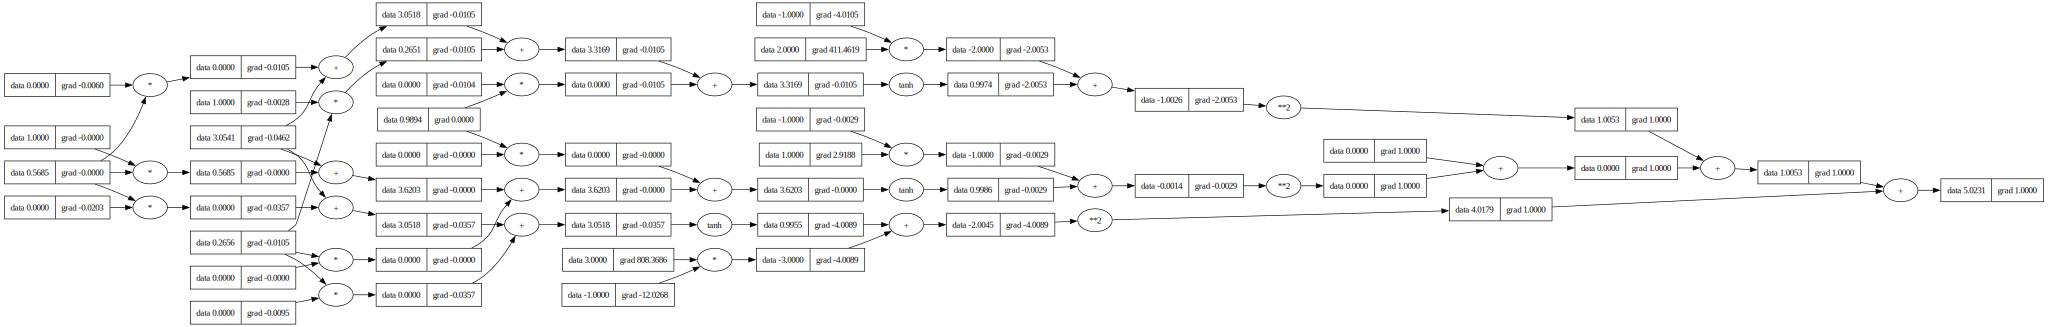

In [17]:
draw_dot(loss)